In [ ]:
# !pip install transformers
# !pip install peft
# !pip install datasets
# !pip install git+https://github.com/huggingface/accelerate.git
# !pip install git+https://github.com/huggingface/transformers.git
# !pip install bitsandbytes

In [1]:
import torch

torch.manual_seed(42)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print("Current CUDA Device:", device_name)
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead")

GPU is available
Current CUDA Device: NVIDIA L40


# Construct a dataset (No need to run this, completed and pushed to the cloud)

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

In [ ]:
columns = ['text_content', 'json_form']
df = pd.DataFrame(columns=columns)

with open ('../test/tool_functions/functions_without_error.txt', 'r') as f:
    data = f.read().split('\n')
for i in range(1, len(data), 3):
    if data[i] != '0x000':
        file_name = data[i-1][11:-3]
        with open('../output/' + file_name + '.txt') as json_form_file:
            json_form = json_form_file.read()
        with open('../free_api_docs/' + file_name, 'r', encoding='utf-8') as html_file:
            html_content = html_file.read()
        soup = BeautifulSoup(html_content, 'html.parser')
        text_content = soup.get_text(separator=' ', strip=True)
        new_row = pd.DataFrame({'text_content': [text_content], 'json_form': [json_form]})
        df = pd.concat([df, new_row], ignore_index=True)

df = df.drop_duplicates(subset=['text_content'])

df.shape

In [ ]:
def max_length(df):
    return {col: df[col].astype(str).map(len).max() for col in df.columns}

max_lengths = max_length(df)

max_lengths

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import Dataset

df.reset_index(drop=True, inplace=True)     # remove default pandas index before converting
hf_dataset = Dataset.from_pandas(df)
repository_name = "doc2json"
private = True
hf_dataset.push_to_hub(repository_name, private=private)

# Prompt tuning - preparation

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
from transformers import AutoModelForCausalLM, AutoModel, AutoTokenizer, default_data_collator, get_linear_schedule_with_warmup, BitsAndBytesConfig
from peft import get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType, PeftModel, PeftConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

In [4]:
model_name_or_path = "meta-llama/Meta-Llama-3-8B-Instruct"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)
peft_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    prompt_tuning_init=PromptTuningInit.TEXT,
    num_virtual_tokens=20,
    prompt_tuning_init_text="You will be given an API documentation. Extract the API endpoints and output in JSON format.",
    tokenizer_name_or_path=model_name_or_path,
)

In [5]:
from IPython.display import display, HTML

checkpoint_name = f"doc2json_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}_v1.pt".replace(
    "/", "_"
)

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

# set pad_token_id equal to the eos_token_id if not set
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

dataset_name = "billyfin/doc2json"
dataset = load_dataset(dataset_name)
example_sample = dataset['train'][166]

example_sample

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'text_content': 'PokÃ©mon TCG Developers PokÃ©mon TCG Developers JOIN THE COMMUNITY OF DEVELOPERS BUILDING WITH THE POKÃ\x89MON TCG API Next The most comprehensive dataset you can find From Base Set through Sword & Shield , the PokÃ©mon TCG API has the card data you need to build the ultimate application, whether that be mobile or web. Get access to prices, hi-res images, and more. Focus on your application and let us worry about the card data. Some features of the PokÃ©mon TCG API include: Prices by TCGplayer Hi-Res Images Detailed Search Queries Developer SDKs With a large community contributing to the project through various SDKs, development for you and your team has never been easier. In-depth details of every card All data delivered in JSON format such as types, attacks, abilities, and more. For Developers The PokÃ©mon TCG API allows developers to ingest card data programatically. The API exposes card and set details in an easy to consume format. Stay up to date with new sets, a

In [6]:
def format(example):
    input_messages = [
        {"role":"user", "content": example_sample['text_content']},
        {"role":"assistant", "content": example_sample['json_form']},
        {"role":"user", "content": example['text_content']},
    ]
    example['text_content'] = tokenizer.apply_chat_template(input_messages, tokenize=False) + "<|start_header_id|>assistant<|end_header_id|>\n\n"
    example['json_form'] += "<|eot_id|>"
    return example

dataset = dataset.map(format)
dataset = dataset.filter(lambda example, idx: idx != 166, with_indices=True)
display(HTML(dataset['train'][0]['text_content'].replace('\n', '<br>')))
display(HTML(dataset['train'][0]['json_form'].replace('\n', '<br>')))

# dataset, dataset['train'][165]

Map:   0%|          | 0/167 [00:00<?, ? examples/s]

Filter:   0%|          | 0/167 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

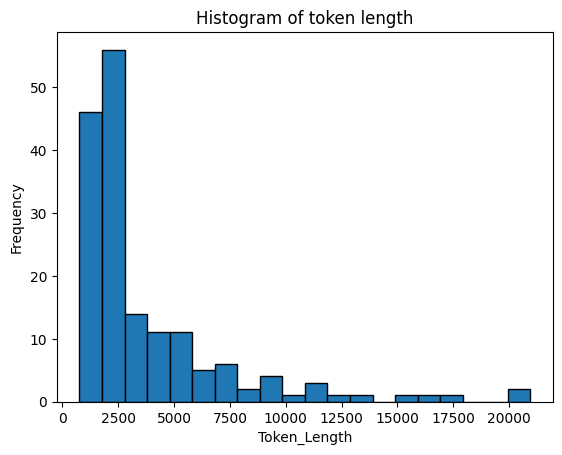

10240

In [7]:
import matplotlib.pyplot as plt

def calculate_max_length(example):
    input_ids = tokenizer(example['text_content'] + example['json_form'])['input_ids']
    return {'length': len(input_ids)}

tokenized_dataset = dataset.map(calculate_max_length)
dataset_length = tokenized_dataset['train']['length']

# Find the maximum tokenized length
max_length = max(dataset_length)

# Plot the diagram for showing distribution of token length
data = tokenized_dataset['train']['length']
plt.hist(data, bins=20, edgecolor='black')
plt.title(f'Histogram of token length')
plt.xlabel('Token_Length')
plt.ylabel('Frequency')
plt.show()

max_length = 10240

max_length

In [8]:
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

text_column = "text_content"
label_column = "json_form"

dataset, dataset["train"][0]

(DatasetDict({
     train: Dataset({
         features: ['text_content', 'json_form'],
         num_rows: 132
     })
     test: Dataset({
         features: ['text_content', 'json_form'],
         num_rows: 34
     })
 }),
 {'text_content': '<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nPokÃ©mon TCG Developers PokÃ©mon TCG Developers JOIN THE COMMUNITY OF DEVELOPERS BUILDING WITH THE POKÃ\x89MON TCG API Next The most comprehensive dataset you can find From Base Set through Sword & Shield , the PokÃ©mon TCG API has the card data you need to build the ultimate application, whether that be mobile or web. Get access to prices, hi-res images, and more. Focus on your application and let us worry about the card data. Some features of the PokÃ©mon TCG API include: Prices by TCGplayer Hi-Res Images Detailed Search Queries Developer SDKs With a large community contributing to the project through various SDKs, development for you and your team has never been easier. In-depth detai

In [ ]:
# def preprocess_function(data):
# #     model_inputs = tokenizer(data["text_content"],
# #                              max_length=8192,
# #                              truncation=True,
# #                              padding="max_length",
# #                             )
# #     labels = tokenizer(text_target=data["json_form"],
# #                        max_length=4096,
# #                        truncation=True,
# #                        padding="max_length",
# #                       )
   
# #     model_inputs["labels"] = labels["input_ids"]
# #     return model_inputs

# # preprocessed_dataset = dataset.map(preprocess_function,fn_kwargs={"tokenizer": tokenizer})
    
   
#    message = [
#        {"role": "system", "content": ""},
#        {"role": "user", "content": data["text_content"]},
#        {"role": "assistant", "content": data["json_form"]}
#    ]
#    data["text"] = tokenizer.apply_chat_template(message, tokenize=False)
#    return data

# column_names = list(dataset["train"].features)
# preprocessed_dataset = dataset.map(preprocess_function,
#                                    remove_columns=column_names,
#                                    batched=False
#                                   )

In [9]:
def preprocess_function(examples):
    batch_size = len(examples[text_column])
    inputs = [f"{x}" for x in examples[text_column]]
    targets = [str(x) for x in examples[label_column]]
    model_inputs = tokenizer(inputs)
    labels = tokenizer(targets)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i] + [tokenizer.pad_token_id]
        # print(i, sample_input_ids, label_input_ids)
        model_inputs["input_ids"][i] = sample_input_ids + label_input_ids
        labels["input_ids"][i] = [-100] * len(sample_input_ids) + label_input_ids
        model_inputs["attention_mask"][i] = [1] * len(model_inputs["input_ids"][i])
    # print(model_inputs)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i]
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        labels["input_ids"][i] = [-100] * (max_length - len(sample_input_ids)) + label_input_ids
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
        labels["input_ids"][i] = torch.tensor(labels["input_ids"][i][:max_length])
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

processed_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/132 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/34 [00:00<?, ? examples/s]

In [10]:
processed_dataset, processed_dataset["train"][0]['input_ids']

(DatasetDict({
     train: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 132
     })
     test: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 34
     })
 }),
 [128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  128009,
  

In [11]:
train_dataset = processed_dataset["train"]
eval_dataset = processed_dataset["test"]
batch_size = 1

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

In [12]:
train_dataset, eval_dataset

(Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 132
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 34
 }))

# Prompt tuning - train

In [13]:
from peft import prepare_model_for_kbit_training

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, 
                                  quantization_config=quant_config,
                                 low_cpu_mem_usage=True,
                                 device_map='auto')
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

model.print_trainable_parameters(), model

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


trainable params: 81,920 || all params: 8,030,343,168 || trainable%: 0.0010


(None,
 PeftModelForCausalLM(
   (base_model): LlamaForCausalLM(
     (model): LlamaModel(
       (embed_tokens): Embedding(128256, 4096)
       (layers): ModuleList(
         (0-31): 32 x LlamaDecoderLayer(
           (self_attn): LlamaSdpaAttention(
             (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
             (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
             (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
             (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
             (rotary_emb): LlamaRotaryEmbedding()
           )
           (mlp): LlamaMLP(
             (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
             (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
             (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
             (act_fn): SiLU()
           )
           (input_layer

## Method 1: Trainer (HuggingFace)

In [ ]:
from transformers import TrainingArguments

trained_model_id = "Llama-3-8B-Instruct-doc2json"

training_args = TrainingArguments(
    output_dir="output",
    learning_rate=2e-3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_strategy="steps",
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    eval_steps=50,
    warmup_steps=5,
    load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
)

trainer.train()

## Method 2: PyTorch

In [14]:
num_epochs = 4
lr = 1e-3
# model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=10,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [15]:
train_loss_per_batch = []
eval_loss_per_batch = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_nan = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)     
        loss = outputs.loss
        if not torch.isnan(loss).any():
            total_loss += loss.detach().float()
        else:
            total_nan += 1
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        print(loss.float())
        train_loss_per_batch.append(loss.detach().float())

    model.eval()
    eval_loss = 0
    eval_preds = []
    eval_nan = 0
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        if not torch.isnan(loss).any():
            eval_loss += loss.detach().float()
            eval_preds.extend(
                tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
            )
        else:
            eval_nan += 1

        eval_loss_per_batch.append(loss.detach().float())

    eval_epoch_loss = eval_loss / (len(eval_dataloader) - eval_nan)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / (len(train_dataloader) - total_nan)
    train_ppl = torch.exp(train_epoch_loss)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}")
    print("train_nan: " + str(total_nan))
    print("eval_nan: " + str(eval_nan))

  0%|          | 0/132 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/workspace/IE/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
  1%|          | 1/132 [00:31<1:08:33, 31.40s/it]

tensor(4.5864, device='cuda:0', grad_fn=<NllLossBackward0>)


  2%|▏         | 2/132 [01:01<1:06:47, 30.83s/it]

tensor(5.5368, device='cuda:0', grad_fn=<NllLossBackward0>)


  2%|▏         | 3/132 [01:32<1:06:11, 30.79s/it]

tensor(2.4830, device='cuda:0', grad_fn=<NllLossBackward0>)


  3%|▎         | 4/132 [01:56<1:00:11, 28.21s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


  4%|▍         | 5/132 [02:28<1:02:25, 29.49s/it]

tensor(3.4205, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▍         | 6/132 [02:59<1:02:57, 29.98s/it]

tensor(4.5426, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▌         | 7/132 [03:30<1:03:12, 30.34s/it]

tensor(4.8032, device='cuda:0', grad_fn=<NllLossBackward0>)


  6%|▌         | 8/132 [04:02<1:03:54, 30.92s/it]

tensor(1.2848, device='cuda:0', grad_fn=<NllLossBackward0>)


  7%|▋         | 9/132 [04:35<1:04:21, 31.39s/it]

tensor(0.4747, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 10/132 [05:06<1:03:31, 31.25s/it]

tensor(2.4168, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 11/132 [05:37<1:02:50, 31.16s/it]

tensor(2.2748, device='cuda:0', grad_fn=<NllLossBackward0>)


  9%|▉         | 12/132 [06:09<1:02:49, 31.41s/it]

tensor(0.1333, device='cuda:0', grad_fn=<NllLossBackward0>)


 10%|▉         | 13/132 [06:40<1:02:06, 31.31s/it]

tensor(1.8414, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█         | 14/132 [07:11<1:01:30, 31.28s/it]

tensor(1.6457, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█▏        | 15/132 [07:42<1:00:52, 31.22s/it]

tensor(1.0557, device='cuda:0', grad_fn=<NllLossBackward0>)


 12%|█▏        | 16/132 [08:15<1:01:10, 31.64s/it]

tensor(0.1604, device='cuda:0', grad_fn=<NllLossBackward0>)


 13%|█▎        | 17/132 [08:46<1:00:22, 31.50s/it]

tensor(0.7812, device='cuda:0', grad_fn=<NllLossBackward0>)


 14%|█▎        | 18/132 [09:17<59:59, 31.58s/it]  

tensor(0.0887, device='cuda:0', grad_fn=<NllLossBackward0>)


 14%|█▍        | 19/132 [09:51<1:00:24, 32.08s/it]

tensor(0.4563, device='cuda:0', grad_fn=<NllLossBackward0>)


 15%|█▌        | 20/132 [10:22<59:18, 31.77s/it]  

tensor(0.5248, device='cuda:0', grad_fn=<NllLossBackward0>)


 16%|█▌        | 21/132 [10:54<59:04, 31.93s/it]

tensor(0.2658, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 22/132 [11:26<58:29, 31.90s/it]

tensor(0.2738, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 23/132 [11:57<57:26, 31.62s/it]

tensor(0.2545, device='cuda:0', grad_fn=<NllLossBackward0>)


 18%|█▊        | 24/132 [12:28<56:31, 31.40s/it]

tensor(0.2690, device='cuda:0', grad_fn=<NllLossBackward0>)


 19%|█▉        | 25/132 [12:59<55:45, 31.27s/it]

tensor(0.1217, device='cuda:0', grad_fn=<NllLossBackward0>)


 20%|█▉        | 26/132 [13:30<55:19, 31.32s/it]

tensor(0.2134, device='cuda:0', grad_fn=<NllLossBackward0>)


 20%|██        | 27/132 [14:02<55:02, 31.45s/it]

tensor(0.2099, device='cuda:0', grad_fn=<NllLossBackward0>)


 21%|██        | 28/132 [14:33<54:16, 31.32s/it]

tensor(0.3755, device='cuda:0', grad_fn=<NllLossBackward0>)


 22%|██▏       | 29/132 [15:05<54:21, 31.66s/it]

tensor(0.2619, device='cuda:0', grad_fn=<NllLossBackward0>)


 23%|██▎       | 30/132 [15:36<53:29, 31.47s/it]

tensor(0.3854, device='cuda:0', grad_fn=<NllLossBackward0>)


 23%|██▎       | 31/132 [16:07<52:42, 31.31s/it]

tensor(0.2967, device='cuda:0', grad_fn=<NllLossBackward0>)


 24%|██▍       | 32/132 [16:32<48:45, 29.26s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 25%|██▌       | 33/132 [17:03<49:07, 29.77s/it]

tensor(0.2178, device='cuda:0', grad_fn=<NllLossBackward0>)


 26%|██▌       | 34/132 [17:34<49:29, 30.31s/it]

tensor(0.0931, device='cuda:0', grad_fn=<NllLossBackward0>)


 27%|██▋       | 35/132 [18:05<49:14, 30.46s/it]

tensor(0.2390, device='cuda:0', grad_fn=<NllLossBackward0>)


 27%|██▋       | 36/132 [18:36<48:52, 30.55s/it]

tensor(0.4116, device='cuda:0', grad_fn=<NllLossBackward0>)


 28%|██▊       | 37/132 [19:07<48:35, 30.69s/it]

tensor(0.0698, device='cuda:0', grad_fn=<NllLossBackward0>)


 29%|██▉       | 38/132 [19:39<48:28, 30.95s/it]

tensor(0.1853, device='cuda:0', grad_fn=<NllLossBackward0>)


 30%|██▉       | 39/132 [20:10<48:00, 30.97s/it]

tensor(0.1099, device='cuda:0', grad_fn=<NllLossBackward0>)


 30%|███       | 40/132 [20:40<47:25, 30.93s/it]

tensor(0.4580, device='cuda:0', grad_fn=<NllLossBackward0>)


 31%|███       | 41/132 [21:11<46:53, 30.92s/it]

tensor(0.2277, device='cuda:0', grad_fn=<NllLossBackward0>)


 32%|███▏      | 42/132 [21:42<46:17, 30.86s/it]

tensor(0.3590, device='cuda:0', grad_fn=<NllLossBackward0>)


 33%|███▎      | 43/132 [22:13<45:47, 30.87s/it]

tensor(0.4517, device='cuda:0', grad_fn=<NllLossBackward0>)


 33%|███▎      | 44/132 [22:44<45:15, 30.86s/it]

tensor(0.1232, device='cuda:0', grad_fn=<NllLossBackward0>)


 34%|███▍      | 45/132 [23:16<45:09, 31.15s/it]

tensor(0.6455, device='cuda:0', grad_fn=<NllLossBackward0>)


 35%|███▍      | 46/132 [23:46<44:33, 31.09s/it]

tensor(0.2796, device='cuda:0', grad_fn=<NllLossBackward0>)


 36%|███▌      | 47/132 [24:18<44:07, 31.15s/it]

tensor(0.1921, device='cuda:0', grad_fn=<NllLossBackward0>)


 36%|███▋      | 48/132 [24:44<41:34, 29.70s/it]

tensor(5.9154, device='cuda:0', grad_fn=<NllLossBackward0>)


 37%|███▋      | 49/132 [25:15<41:46, 30.20s/it]

tensor(0.1110, device='cuda:0', grad_fn=<NllLossBackward0>)


 38%|███▊      | 50/132 [25:48<42:12, 30.88s/it]

tensor(0.3357, device='cuda:0', grad_fn=<NllLossBackward0>)


 39%|███▊      | 51/132 [26:19<41:53, 31.03s/it]

tensor(0.0985, device='cuda:0', grad_fn=<NllLossBackward0>)


 39%|███▉      | 52/132 [26:50<41:26, 31.08s/it]

tensor(0.3147, device='cuda:0', grad_fn=<NllLossBackward0>)


 40%|████      | 53/132 [27:22<40:58, 31.12s/it]

tensor(0.4949, device='cuda:0', grad_fn=<NllLossBackward0>)


 41%|████      | 54/132 [27:46<37:53, 29.14s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 42%|████▏     | 55/132 [28:17<38:12, 29.77s/it]

tensor(0.2772, device='cuda:0', grad_fn=<NllLossBackward0>)


 42%|████▏     | 56/132 [28:50<38:48, 30.64s/it]

tensor(0.2993, device='cuda:0', grad_fn=<NllLossBackward0>)


 43%|████▎     | 57/132 [29:22<38:47, 31.04s/it]

tensor(0.0957, device='cuda:0', grad_fn=<NllLossBackward0>)


 44%|████▍     | 58/132 [29:53<38:15, 31.01s/it]

tensor(0.1857, device='cuda:0', grad_fn=<NllLossBackward0>)


 45%|████▍     | 59/132 [30:25<38:14, 31.43s/it]

tensor(0.1579, device='cuda:0', grad_fn=<NllLossBackward0>)


 45%|████▌     | 60/132 [30:57<37:44, 31.46s/it]

tensor(0.2321, device='cuda:0', grad_fn=<NllLossBackward0>)


 46%|████▌     | 61/132 [31:28<37:11, 31.42s/it]

tensor(0.4208, device='cuda:0', grad_fn=<NllLossBackward0>)


 47%|████▋     | 62/132 [31:59<36:30, 31.30s/it]

tensor(0.3897, device='cuda:0', grad_fn=<NllLossBackward0>)


 48%|████▊     | 63/132 [32:30<35:55, 31.25s/it]

tensor(0.5418, device='cuda:0', grad_fn=<NllLossBackward0>)


 48%|████▊     | 64/132 [33:02<35:22, 31.21s/it]

tensor(0.3441, device='cuda:0', grad_fn=<NllLossBackward0>)


 49%|████▉     | 65/132 [33:32<34:44, 31.12s/it]

tensor(0.4025, device='cuda:0', grad_fn=<NllLossBackward0>)


 50%|█████     | 66/132 [34:04<34:27, 31.32s/it]

tensor(0.1089, device='cuda:0', grad_fn=<NllLossBackward0>)


 51%|█████     | 67/132 [34:31<32:20, 29.85s/it]

tensor(6.3680, device='cuda:0', grad_fn=<NllLossBackward0>)


 52%|█████▏    | 68/132 [35:02<32:19, 30.30s/it]

tensor(0.1157, device='cuda:0', grad_fn=<NllLossBackward0>)


 52%|█████▏    | 69/132 [35:33<32:09, 30.62s/it]

tensor(0.4599, device='cuda:0', grad_fn=<NllLossBackward0>)


 53%|█████▎    | 70/132 [36:04<31:45, 30.73s/it]

tensor(0.3340, device='cuda:0', grad_fn=<NllLossBackward0>)


 54%|█████▍    | 71/132 [36:36<31:22, 30.86s/it]

tensor(0.1107, device='cuda:0', grad_fn=<NllLossBackward0>)


 55%|█████▍    | 72/132 [37:07<30:55, 30.92s/it]

tensor(0.3000, device='cuda:0', grad_fn=<NllLossBackward0>)


 55%|█████▌    | 73/132 [37:38<30:26, 30.96s/it]

tensor(0.3049, device='cuda:0', grad_fn=<NllLossBackward0>)


 56%|█████▌    | 74/132 [38:10<30:27, 31.51s/it]

tensor(1.0274, device='cuda:0', grad_fn=<NllLossBackward0>)


 57%|█████▋    | 75/132 [38:42<29:50, 31.42s/it]

tensor(0.3437, device='cuda:0', grad_fn=<NllLossBackward0>)


 58%|█████▊    | 76/132 [39:13<29:16, 31.36s/it]

tensor(0.2130, device='cuda:0', grad_fn=<NllLossBackward0>)


 58%|█████▊    | 77/132 [39:45<29:04, 31.71s/it]

tensor(0.1826, device='cuda:0', grad_fn=<NllLossBackward0>)


 59%|█████▉    | 78/132 [40:10<26:37, 29.58s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 60%|█████▉    | 79/132 [40:41<26:28, 29.98s/it]

tensor(0.2133, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████    | 80/132 [41:12<26:22, 30.43s/it]

tensor(0.1360, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████▏   | 81/132 [41:43<25:58, 30.55s/it]

tensor(1.9208, device='cuda:0', grad_fn=<NllLossBackward0>)


 62%|██████▏   | 82/132 [42:15<25:43, 30.87s/it]

tensor(0.1263, device='cuda:0', grad_fn=<NllLossBackward0>)


 63%|██████▎   | 83/132 [42:47<25:28, 31.19s/it]

tensor(0.3271, device='cuda:0', grad_fn=<NllLossBackward0>)


 64%|██████▎   | 84/132 [43:11<23:21, 29.21s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 64%|██████▍   | 85/132 [43:42<23:18, 29.76s/it]

tensor(0.3816, device='cuda:0', grad_fn=<NllLossBackward0>)


 65%|██████▌   | 86/132 [44:14<23:08, 30.19s/it]

tensor(0.1893, device='cuda:0', grad_fn=<NllLossBackward0>)


 66%|██████▌   | 87/132 [44:45<22:49, 30.44s/it]

tensor(0.3063, device='cuda:0', grad_fn=<NllLossBackward0>)


 67%|██████▋   | 88/132 [45:16<22:30, 30.69s/it]

tensor(0.2139, device='cuda:0', grad_fn=<NllLossBackward0>)


 67%|██████▋   | 89/132 [45:47<22:10, 30.95s/it]

tensor(0.1044, device='cuda:0', grad_fn=<NllLossBackward0>)


 68%|██████▊   | 90/132 [46:19<21:40, 30.97s/it]

tensor(0.3755, device='cuda:0', grad_fn=<NllLossBackward0>)


 69%|██████▉   | 91/132 [46:50<21:11, 31.00s/it]

tensor(0.2628, device='cuda:0', grad_fn=<NllLossBackward0>)


 71%|███████   | 94/132 [48:23<19:41, 31.08s/it]

tensor(0.1427, device='cuda:0', grad_fn=<NllLossBackward0>)


 72%|███████▏  | 95/132 [48:55<19:22, 31.42s/it]

tensor(0.1461, device='cuda:0', grad_fn=<NllLossBackward0>)


 73%|███████▎  | 96/132 [49:26<18:47, 31.33s/it]

tensor(0.2070, device='cuda:0', grad_fn=<NllLossBackward0>)


 74%|███████▍  | 98/132 [50:28<17:40, 31.19s/it]

tensor(0.5631, device='cuda:0', grad_fn=<NllLossBackward0>)


 75%|███████▌  | 99/132 [50:59<17:07, 31.14s/it]

tensor(0.0800, device='cuda:0', grad_fn=<NllLossBackward0>)


 76%|███████▌  | 100/132 [51:30<16:33, 31.06s/it]

tensor(0.0656, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 101/132 [52:01<16:02, 31.06s/it]

tensor(0.1494, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 102/132 [52:32<15:32, 31.07s/it]

tensor(0.2080, device='cuda:0', grad_fn=<NllLossBackward0>)


 78%|███████▊  | 103/132 [53:04<15:02, 31.13s/it]

tensor(0.2674, device='cuda:0', grad_fn=<NllLossBackward0>)


 79%|███████▉  | 104/132 [53:35<14:30, 31.08s/it]

tensor(0.2801, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|███████▉  | 105/132 [54:06<14:04, 31.28s/it]

tensor(0.0717, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|████████  | 106/132 [54:37<13:31, 31.20s/it]

tensor(0.0979, device='cuda:0', grad_fn=<NllLossBackward0>)


 81%|████████  | 107/132 [55:09<12:59, 31.18s/it]

tensor(0.1561, device='cuda:0', grad_fn=<NllLossBackward0>)


 82%|████████▏ | 108/132 [55:39<12:25, 31.08s/it]

tensor(0.3004, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 109/132 [56:11<11:55, 31.11s/it]

tensor(0.1391, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 110/132 [56:42<11:24, 31.12s/it]

tensor(0.1577, device='cuda:0', grad_fn=<NllLossBackward0>)


 84%|████████▍ | 111/132 [57:13<10:53, 31.12s/it]

tensor(0.0960, device='cuda:0', grad_fn=<NllLossBackward0>)


 85%|████████▍ | 112/132 [57:45<10:25, 31.29s/it]

tensor(0.0823, device='cuda:0', grad_fn=<NllLossBackward0>)


 86%|████████▌ | 113/132 [58:17<10:03, 31.76s/it]

tensor(0.8182, device='cuda:0', grad_fn=<NllLossBackward0>)


 86%|████████▋ | 114/132 [58:48<09:27, 31.54s/it]

tensor(0.1469, device='cuda:0', grad_fn=<NllLossBackward0>)


 87%|████████▋ | 115/132 [59:21<09:01, 31.86s/it]

tensor(0.0630, device='cuda:0', grad_fn=<NllLossBackward0>)


 88%|████████▊ | 116/132 [59:52<08:26, 31.68s/it]

tensor(0.0323, device='cuda:0', grad_fn=<NllLossBackward0>)


 89%|████████▊ | 117/132 [1:00:23<07:52, 31.47s/it]

tensor(0.1789, device='cuda:0', grad_fn=<NllLossBackward0>)


 89%|████████▉ | 118/132 [1:00:54<07:17, 31.28s/it]

tensor(0.1721, device='cuda:0', grad_fn=<NllLossBackward0>)


 90%|█████████ | 119/132 [1:01:25<06:45, 31.22s/it]

tensor(0.2205, device='cuda:0', grad_fn=<NllLossBackward0>)


 91%|█████████ | 120/132 [1:01:56<06:14, 31.18s/it]

tensor(0.0955, device='cuda:0', grad_fn=<NllLossBackward0>)


 92%|█████████▏| 121/132 [1:02:28<05:43, 31.20s/it]

tensor(0.0863, device='cuda:0', grad_fn=<NllLossBackward0>)


 92%|█████████▏| 122/132 [1:02:59<05:11, 31.15s/it]

tensor(0.1732, device='cuda:0', grad_fn=<NllLossBackward0>)


 93%|█████████▎| 123/132 [1:03:30<04:40, 31.14s/it]

tensor(0.0793, device='cuda:0', grad_fn=<NllLossBackward0>)


 94%|█████████▍| 124/132 [1:04:01<04:09, 31.14s/it]

tensor(0.1165, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▍| 125/132 [1:04:27<03:27, 29.71s/it]

tensor(5.3246, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▌| 126/132 [1:04:58<03:00, 30.14s/it]

tensor(0.1835, device='cuda:0', grad_fn=<NllLossBackward0>)


 96%|█████████▌| 127/132 [1:05:29<02:32, 30.42s/it]

tensor(0.1923, device='cuda:0', grad_fn=<NllLossBackward0>)


 97%|█████████▋| 128/132 [1:05:54<01:54, 28.66s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 98%|█████████▊| 129/132 [1:06:25<01:28, 29.39s/it]

tensor(0.0734, device='cuda:0', grad_fn=<NllLossBackward0>)


 98%|█████████▊| 130/132 [1:06:56<00:59, 29.88s/it]

tensor(0.2030, device='cuda:0', grad_fn=<NllLossBackward0>)


 99%|█████████▉| 131/132 [1:07:27<00:30, 30.23s/it]

tensor(0.3071, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 132/132 [1:07:59<00:00, 30.90s/it]


tensor(0.1340, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 34/34 [05:28<00:00,  9.65s/it]


epoch=0: train_ppl=tensor(1.9300, device='cuda:0') train_epoch_loss=tensor(0.6575, device='cuda:0') eval_ppl=tensor(1.3674, device='cuda:0') eval_epoch_loss=tensor(0.3129, device='cuda:0')
train_nan: 6
eval_nan: 0


  1%|          | 1/132 [00:31<1:07:53, 31.09s/it]

tensor(0.3056, device='cuda:0', grad_fn=<NllLossBackward0>)


  2%|▏         | 2/132 [01:02<1:07:20, 31.08s/it]

tensor(0.1575, device='cuda:0', grad_fn=<NllLossBackward0>)


  2%|▏         | 3/132 [01:33<1:06:42, 31.02s/it]

tensor(0.1740, device='cuda:0', grad_fn=<NllLossBackward0>)


  3%|▎         | 4/132 [02:04<1:06:10, 31.02s/it]

tensor(0.2920, device='cuda:0', grad_fn=<NllLossBackward0>)


  4%|▍         | 5/132 [02:35<1:06:15, 31.30s/it]

tensor(0.1723, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▍         | 6/132 [03:08<1:06:33, 31.70s/it]

tensor(0.1964, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▌         | 7/132 [03:39<1:05:40, 31.52s/it]

tensor(0.0972, device='cuda:0', grad_fn=<NllLossBackward0>)


  6%|▌         | 8/132 [04:10<1:04:56, 31.43s/it]

tensor(0.1910, device='cuda:0', grad_fn=<NllLossBackward0>)


  7%|▋         | 9/132 [04:41<1:04:16, 31.35s/it]

tensor(0.0792, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 10/132 [05:14<1:04:17, 31.62s/it]

tensor(0.1202, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 11/132 [05:45<1:03:24, 31.44s/it]

tensor(0.2427, device='cuda:0', grad_fn=<NllLossBackward0>)


  9%|▉         | 12/132 [06:16<1:02:38, 31.32s/it]

tensor(0.1883, device='cuda:0', grad_fn=<NllLossBackward0>)


 10%|▉         | 13/132 [06:49<1:03:11, 31.86s/it]

tensor(0.5289, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█         | 14/132 [07:21<1:02:39, 31.86s/it]

tensor(0.0553, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█▏        | 15/132 [07:53<1:02:07, 31.86s/it]

tensor(0.4823, device='cuda:0', grad_fn=<NllLossBackward0>)


 12%|█▏        | 16/132 [08:17<57:19, 29.65s/it]  

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 13%|█▎        | 17/132 [08:48<57:39, 30.08s/it]

tensor(0.0799, device='cuda:0', grad_fn=<NllLossBackward0>)


 14%|█▎        | 18/132 [09:20<58:07, 30.59s/it]

tensor(0.1024, device='cuda:0', grad_fn=<NllLossBackward0>)


 14%|█▍        | 19/132 [09:46<55:14, 29.33s/it]

tensor(4.2727, device='cuda:0', grad_fn=<NllLossBackward0>)


 15%|█▌        | 20/132 [10:18<55:46, 29.88s/it]

tensor(0.2288, device='cuda:0', grad_fn=<NllLossBackward0>)


 16%|█▌        | 21/132 [10:49<56:03, 30.31s/it]

tensor(0.1282, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 22/132 [11:15<53:24, 29.13s/it]

tensor(3.8242, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 23/132 [11:47<54:25, 29.96s/it]

tensor(0.0471, device='cuda:0', grad_fn=<NllLossBackward0>)


 18%|█▊        | 24/132 [12:18<54:33, 30.31s/it]

tensor(0.0449, device='cuda:0', grad_fn=<NllLossBackward0>)


 19%|█▉        | 25/132 [12:49<54:28, 30.55s/it]

tensor(0.3105, device='cuda:0', grad_fn=<NllLossBackward0>)


 20%|█▉        | 26/132 [13:21<54:38, 30.93s/it]

tensor(0.1393, device='cuda:0', grad_fn=<NllLossBackward0>)


 20%|██        | 27/132 [13:52<54:19, 31.05s/it]

tensor(0.2028, device='cuda:0', grad_fn=<NllLossBackward0>)


 21%|██        | 28/132 [14:24<54:04, 31.20s/it]

tensor(0.1094, device='cuda:0', grad_fn=<NllLossBackward0>)


 22%|██▏       | 29/132 [14:55<53:38, 31.25s/it]

tensor(0.0732, device='cuda:0', grad_fn=<NllLossBackward0>)


 23%|██▎       | 30/132 [15:27<53:13, 31.31s/it]

tensor(0.0972, device='cuda:0', grad_fn=<NllLossBackward0>)


 23%|██▎       | 31/132 [15:58<52:36, 31.25s/it]

tensor(0.1097, device='cuda:0', grad_fn=<NllLossBackward0>)


 24%|██▍       | 32/132 [16:29<52:13, 31.33s/it]

tensor(0.1009, device='cuda:0', grad_fn=<NllLossBackward0>)


 25%|██▌       | 33/132 [17:00<51:27, 31.19s/it]

tensor(0.1270, device='cuda:0', grad_fn=<NllLossBackward0>)


 26%|██▌       | 34/132 [17:31<50:54, 31.16s/it]

tensor(0.1333, device='cuda:0', grad_fn=<NllLossBackward0>)


 27%|██▋       | 35/132 [18:04<51:01, 31.56s/it]

tensor(0.0868, device='cuda:0', grad_fn=<NllLossBackward0>)


 27%|██▋       | 36/132 [18:35<50:13, 31.39s/it]

tensor(0.0967, device='cuda:0', grad_fn=<NllLossBackward0>)


 28%|██▊       | 37/132 [19:06<49:32, 31.29s/it]

tensor(0.0845, device='cuda:0', grad_fn=<NllLossBackward0>)


 29%|██▉       | 38/132 [19:37<49:05, 31.34s/it]

tensor(0.1520, device='cuda:0', grad_fn=<NllLossBackward0>)


 30%|██▉       | 39/132 [20:09<48:53, 31.54s/it]

tensor(0.2313, device='cuda:0', grad_fn=<NllLossBackward0>)


 30%|███       | 40/132 [20:42<48:36, 31.71s/it]

tensor(0.1219, device='cuda:0', grad_fn=<NllLossBackward0>)


 31%|███       | 41/132 [21:14<48:32, 32.01s/it]

tensor(0.2225, device='cuda:0', grad_fn=<NllLossBackward0>)


 32%|███▏      | 42/132 [21:47<48:26, 32.29s/it]

tensor(0.6070, device='cuda:0', grad_fn=<NllLossBackward0>)


 33%|███▎      | 43/132 [22:18<47:24, 31.96s/it]

tensor(0.0573, device='cuda:0', grad_fn=<NllLossBackward0>)


 33%|███▎      | 44/132 [22:50<46:53, 31.97s/it]

tensor(0.0560, device='cuda:0', grad_fn=<NllLossBackward0>)


 34%|███▍      | 45/132 [23:22<46:00, 31.73s/it]

tensor(0.1239, device='cuda:0', grad_fn=<NllLossBackward0>)


 35%|███▍      | 46/132 [23:53<45:27, 31.72s/it]

tensor(0.0710, device='cuda:0', grad_fn=<NllLossBackward0>)


 36%|███▌      | 47/132 [24:25<44:59, 31.75s/it]

tensor(0.0954, device='cuda:0', grad_fn=<NllLossBackward0>)


 36%|███▋      | 48/132 [24:56<44:12, 31.57s/it]

tensor(0.1001, device='cuda:0', grad_fn=<NllLossBackward0>)


 37%|███▋      | 49/132 [25:27<43:31, 31.46s/it]

tensor(0.1344, device='cuda:0', grad_fn=<NllLossBackward0>)


 38%|███▊      | 50/132 [25:59<43:00, 31.47s/it]

tensor(0.1255, device='cuda:0', grad_fn=<NllLossBackward0>)


 39%|███▊      | 51/132 [26:25<40:25, 29.94s/it]

tensor(3.4190, device='cuda:0', grad_fn=<NllLossBackward0>)


 39%|███▉      | 52/132 [26:57<40:34, 30.43s/it]

tensor(0.0737, device='cuda:0', grad_fn=<NllLossBackward0>)


 40%|████      | 53/132 [27:21<37:45, 28.68s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 41%|████      | 54/132 [27:52<38:12, 29.38s/it]

tensor(0.0733, device='cuda:0', grad_fn=<NllLossBackward0>)


 42%|████▏     | 55/132 [28:24<38:23, 29.92s/it]

tensor(0.2562, device='cuda:0', grad_fn=<NllLossBackward0>)


 42%|████▏     | 56/132 [28:55<38:22, 30.30s/it]

tensor(0.1878, device='cuda:0', grad_fn=<NllLossBackward0>)


 43%|████▎     | 57/132 [29:26<38:11, 30.56s/it]

tensor(0.1375, device='cuda:0', grad_fn=<NllLossBackward0>)


 44%|████▍     | 58/132 [29:59<38:25, 31.16s/it]

tensor(0.0629, device='cuda:0', grad_fn=<NllLossBackward0>)


 45%|████▍     | 59/132 [30:30<37:53, 31.14s/it]

tensor(0.1831, device='cuda:0', grad_fn=<NllLossBackward0>)


 45%|████▌     | 60/132 [31:01<37:28, 31.22s/it]

tensor(0.0572, device='cuda:0', grad_fn=<NllLossBackward0>)


 46%|████▌     | 61/132 [31:32<36:52, 31.16s/it]

tensor(0.1435, device='cuda:0', grad_fn=<NllLossBackward0>)


 47%|████▋     | 62/132 [32:03<36:18, 31.12s/it]

tensor(0.1190, device='cuda:0', grad_fn=<NllLossBackward0>)


 48%|████▊     | 63/132 [32:34<35:46, 31.10s/it]

tensor(0.1059, device='cuda:0', grad_fn=<NllLossBackward0>)


 48%|████▊     | 64/132 [33:05<35:14, 31.10s/it]

tensor(0.2033, device='cuda:0', grad_fn=<NllLossBackward0>)


 49%|████▉     | 65/132 [33:36<34:42, 31.08s/it]

tensor(0.2383, device='cuda:0', grad_fn=<NllLossBackward0>)


 50%|█████     | 66/132 [34:07<34:09, 31.06s/it]

tensor(0.0804, device='cuda:0', grad_fn=<NllLossBackward0>)


 51%|█████     | 67/132 [34:38<33:40, 31.09s/it]

tensor(0.1211, device='cuda:0', grad_fn=<NllLossBackward0>)


 52%|█████▏    | 68/132 [35:10<33:18, 31.23s/it]

tensor(0.0697, device='cuda:0', grad_fn=<NllLossBackward0>)


 52%|█████▏    | 69/132 [35:41<32:41, 31.13s/it]

tensor(0.1108, device='cuda:0', grad_fn=<NllLossBackward0>)


 53%|█████▎    | 70/132 [36:13<32:22, 31.34s/it]

tensor(0.0792, device='cuda:0', grad_fn=<NllLossBackward0>)


 54%|█████▍    | 71/132 [36:44<31:57, 31.44s/it]

tensor(0.0648, device='cuda:0', grad_fn=<NllLossBackward0>)


 55%|█████▍    | 72/132 [37:15<31:17, 31.29s/it]

tensor(0.0405, device='cuda:0', grad_fn=<NllLossBackward0>)


 55%|█████▌    | 73/132 [37:46<30:42, 31.22s/it]

tensor(0.0913, device='cuda:0', grad_fn=<NllLossBackward0>)


 56%|█████▌    | 74/132 [38:18<30:08, 31.19s/it]

tensor(0.0509, device='cuda:0', grad_fn=<NllLossBackward0>)


 57%|█████▋    | 75/132 [38:48<29:31, 31.08s/it]

tensor(0.1176, device='cuda:0', grad_fn=<NllLossBackward0>)


 58%|█████▊    | 76/132 [39:19<28:59, 31.06s/it]

tensor(0.1065, device='cuda:0', grad_fn=<NllLossBackward0>)


 58%|█████▊    | 77/132 [39:50<28:28, 31.06s/it]

tensor(0.0929, device='cuda:0', grad_fn=<NllLossBackward0>)


 59%|█████▉    | 78/132 [40:23<28:19, 31.48s/it]

tensor(0.0915, device='cuda:0', grad_fn=<NllLossBackward0>)


 60%|█████▉    | 79/132 [40:56<28:09, 31.87s/it]

tensor(0.3505, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████    | 80/132 [41:20<25:42, 29.67s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████▏   | 81/132 [41:52<25:46, 30.33s/it]

tensor(0.0744, device='cuda:0', grad_fn=<NllLossBackward0>)


 64%|██████▎   | 84/132 [43:25<24:41, 30.86s/it]

tensor(0.1134, device='cuda:0', grad_fn=<NllLossBackward0>)


 64%|██████▍   | 85/132 [43:56<24:12, 30.90s/it]

tensor(0.0351, device='cuda:0', grad_fn=<NllLossBackward0>)


 65%|██████▌   | 86/132 [44:28<23:44, 30.98s/it]

tensor(0.0249, device='cuda:0', grad_fn=<NllLossBackward0>)


 66%|██████▌   | 87/132 [44:59<23:15, 31.02s/it]

tensor(0.1250, device='cuda:0', grad_fn=<NllLossBackward0>)


 67%|██████▋   | 88/132 [45:23<21:18, 29.06s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 67%|██████▋   | 89/132 [45:48<19:51, 27.70s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 68%|██████▊   | 90/132 [46:19<20:08, 28.78s/it]

tensor(0.0506, device='cuda:0', grad_fn=<NllLossBackward0>)


 69%|██████▉   | 91/132 [46:50<20:07, 29.46s/it]

tensor(0.1203, device='cuda:0', grad_fn=<NllLossBackward0>)


 70%|██████▉   | 92/132 [47:21<19:54, 29.85s/it]

tensor(0.4043, device='cuda:0', grad_fn=<NllLossBackward0>)


 70%|███████   | 93/132 [47:52<19:37, 30.18s/it]

tensor(0.1879, device='cuda:0', grad_fn=<NllLossBackward0>)


 71%|███████   | 94/132 [48:23<19:16, 30.44s/it]

tensor(0.0940, device='cuda:0', grad_fn=<NllLossBackward0>)


 72%|███████▏  | 95/132 [48:54<18:54, 30.65s/it]

tensor(0.0841, device='cuda:0', grad_fn=<NllLossBackward0>)


 73%|███████▎  | 96/132 [49:26<18:34, 30.95s/it]

tensor(0.0894, device='cuda:0', grad_fn=<NllLossBackward0>)


 73%|███████▎  | 97/132 [49:57<18:06, 31.06s/it]

tensor(0.1850, device='cuda:0', grad_fn=<NllLossBackward0>)


 74%|███████▍  | 98/132 [50:28<17:34, 31.00s/it]

tensor(0.1239, device='cuda:0', grad_fn=<NllLossBackward0>)


 75%|███████▌  | 99/132 [50:59<17:05, 31.07s/it]

tensor(0.1792, device='cuda:0', grad_fn=<NllLossBackward0>)


 76%|███████▌  | 100/132 [51:30<16:34, 31.09s/it]

tensor(0.0632, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 101/132 [52:02<16:09, 31.28s/it]

tensor(0.0495, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 102/132 [52:33<15:34, 31.14s/it]

tensor(0.1145, device='cuda:0', grad_fn=<NllLossBackward0>)


 78%|███████▊  | 103/132 [53:04<15:02, 31.14s/it]

tensor(0.0803, device='cuda:0', grad_fn=<NllLossBackward0>)


 79%|███████▉  | 104/132 [53:35<14:30, 31.11s/it]

tensor(0.0724, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|███████▉  | 105/132 [54:06<13:58, 31.07s/it]

tensor(0.0909, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|████████  | 106/132 [54:37<13:28, 31.08s/it]

tensor(0.0875, device='cuda:0', grad_fn=<NllLossBackward0>)


 81%|████████  | 107/132 [55:08<12:57, 31.08s/it]

tensor(0.3022, device='cuda:0', grad_fn=<NllLossBackward0>)


 82%|████████▏ | 108/132 [55:39<12:25, 31.07s/it]

tensor(0.0446, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 109/132 [56:10<11:55, 31.10s/it]

tensor(0.1553, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 110/132 [56:41<11:23, 31.08s/it]

tensor(0.1075, device='cuda:0', grad_fn=<NllLossBackward0>)


 84%|████████▍ | 111/132 [57:14<10:59, 31.42s/it]

tensor(0.0928, device='cuda:0', grad_fn=<NllLossBackward0>)


 85%|████████▍ | 112/132 [57:45<10:26, 31.30s/it]

tensor(0.0547, device='cuda:0', grad_fn=<NllLossBackward0>)


 86%|████████▌ | 113/132 [58:16<09:53, 31.23s/it]

tensor(0.0606, device='cuda:0', grad_fn=<NllLossBackward0>)


 86%|████████▋ | 114/132 [58:47<09:20, 31.14s/it]

tensor(0.2170, device='cuda:0', grad_fn=<NllLossBackward0>)


 87%|████████▋ | 115/132 [59:18<08:48, 31.10s/it]

tensor(0.1229, device='cuda:0', grad_fn=<NllLossBackward0>)


 88%|████████▊ | 116/132 [59:49<08:17, 31.11s/it]

tensor(0.0639, device='cuda:0', grad_fn=<NllLossBackward0>)


 89%|████████▊ | 117/132 [1:00:21<07:50, 31.33s/it]

tensor(0.0827, device='cuda:0', grad_fn=<NllLossBackward0>)


 89%|████████▉ | 118/132 [1:00:52<07:17, 31.28s/it]

tensor(0.1031, device='cuda:0', grad_fn=<NllLossBackward0>)


 90%|█████████ | 119/132 [1:01:23<06:45, 31.17s/it]

tensor(0.7816, device='cuda:0', grad_fn=<NllLossBackward0>)


 91%|█████████ | 120/132 [1:01:54<06:13, 31.10s/it]

tensor(0.1337, device='cuda:0', grad_fn=<NllLossBackward0>)


 92%|█████████▏| 121/132 [1:02:25<05:41, 31.08s/it]

tensor(0.1653, device='cuda:0', grad_fn=<NllLossBackward0>)


 92%|█████████▏| 122/132 [1:02:56<05:10, 31.08s/it]

tensor(0.0708, device='cuda:0', grad_fn=<NllLossBackward0>)


 93%|█████████▎| 123/132 [1:03:27<04:39, 31.07s/it]

tensor(0.0313, device='cuda:0', grad_fn=<NllLossBackward0>)


 94%|█████████▍| 124/132 [1:03:58<04:08, 31.04s/it]

tensor(0.1186, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▍| 125/132 [1:04:30<03:40, 31.52s/it]

tensor(0.0628, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▌| 126/132 [1:04:55<02:56, 29.44s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 96%|█████████▌| 127/132 [1:05:26<02:29, 29.94s/it]

tensor(0.1964, device='cuda:0', grad_fn=<NllLossBackward0>)


 97%|█████████▋| 128/132 [1:05:59<02:02, 30.72s/it]

tensor(0.1010, device='cuda:0', grad_fn=<NllLossBackward0>)


 98%|█████████▊| 129/132 [1:06:30<01:32, 30.85s/it]

tensor(0.1511, device='cuda:0', grad_fn=<NllLossBackward0>)


 98%|█████████▊| 130/132 [1:07:02<01:02, 31.35s/it]

tensor(0.1194, device='cuda:0', grad_fn=<NllLossBackward0>)


 99%|█████████▉| 131/132 [1:07:33<00:31, 31.29s/it]

tensor(0.1388, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 132/132 [1:08:05<00:00, 30.95s/it]


tensor(0.2094, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 34/34 [05:29<00:00,  9.69s/it]


epoch=1: train_ppl=tensor(1.2589, device='cuda:0') train_epoch_loss=tensor(0.2303, device='cuda:0') eval_ppl=tensor(1.2743, device='cuda:0') eval_epoch_loss=tensor(0.2424, device='cuda:0')
train_nan: 6
eval_nan: 0


  1%|          | 1/132 [00:31<1:07:44, 31.02s/it]

tensor(0.1106, device='cuda:0', grad_fn=<NllLossBackward0>)


  2%|▏         | 2/132 [01:02<1:07:59, 31.38s/it]

tensor(0.1223, device='cuda:0', grad_fn=<NllLossBackward0>)


  2%|▏         | 3/132 [01:33<1:07:13, 31.27s/it]

tensor(0.0544, device='cuda:0', grad_fn=<NllLossBackward0>)


  3%|▎         | 4/132 [02:04<1:06:35, 31.22s/it]

tensor(0.0660, device='cuda:0', grad_fn=<NllLossBackward0>)


  4%|▍         | 5/132 [02:35<1:05:55, 31.15s/it]

tensor(0.1030, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▍         | 6/132 [03:06<1:05:14, 31.07s/it]

tensor(0.1485, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▌         | 7/132 [03:38<1:04:53, 31.15s/it]

tensor(0.1718, device='cuda:0', grad_fn=<NllLossBackward0>)


  6%|▌         | 8/132 [04:09<1:04:20, 31.13s/it]

tensor(0.1186, device='cuda:0', grad_fn=<NllLossBackward0>)


  7%|▋         | 9/132 [04:40<1:03:49, 31.14s/it]

tensor(0.0722, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 10/132 [05:12<1:04:09, 31.56s/it]

tensor(0.1055, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 11/132 [05:43<1:03:18, 31.39s/it]

tensor(0.0866, device='cuda:0', grad_fn=<NllLossBackward0>)


  9%|▉         | 12/132 [06:14<1:02:32, 31.27s/it]

tensor(0.2042, device='cuda:0', grad_fn=<NllLossBackward0>)


 10%|▉         | 13/132 [06:45<1:01:48, 31.16s/it]

tensor(0.1492, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█         | 14/132 [07:10<57:21, 29.17s/it]  

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█▏        | 15/132 [07:42<58:49, 30.17s/it]

tensor(0.0492, device='cuda:0', grad_fn=<NllLossBackward0>)


 12%|█▏        | 16/132 [08:13<58:50, 30.43s/it]

tensor(0.0447, device='cuda:0', grad_fn=<NllLossBackward0>)


 13%|█▎        | 17/132 [08:45<58:43, 30.64s/it]

tensor(0.0972, device='cuda:0', grad_fn=<NllLossBackward0>)


 14%|█▎        | 18/132 [09:16<58:30, 30.79s/it]

tensor(0.1097, device='cuda:0', grad_fn=<NllLossBackward0>)


 14%|█▍        | 19/132 [09:47<58:12, 30.91s/it]

tensor(0.0395, device='cuda:0', grad_fn=<NllLossBackward0>)


 15%|█▌        | 20/132 [10:11<54:04, 28.97s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 16%|█▌        | 21/132 [10:43<54:50, 29.65s/it]

tensor(0.0473, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 22/132 [11:07<51:32, 28.12s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 23/132 [11:38<52:40, 29.00s/it]

tensor(0.0580, device='cuda:0', grad_fn=<NllLossBackward0>)


 18%|█▊        | 24/132 [12:09<53:18, 29.62s/it]

tensor(0.0553, device='cuda:0', grad_fn=<NllLossBackward0>)


 19%|█▉        | 25/132 [12:41<53:57, 30.26s/it]

tensor(0.0690, device='cuda:0', grad_fn=<NllLossBackward0>)


 20%|█▉        | 26/132 [13:13<54:21, 30.77s/it]

tensor(0.0562, device='cuda:0', grad_fn=<NllLossBackward0>)


 20%|██        | 27/132 [13:45<54:25, 31.10s/it]

tensor(0.0689, device='cuda:0', grad_fn=<NllLossBackward0>)


 21%|██        | 28/132 [14:11<51:28, 29.70s/it]

tensor(3.9388, device='cuda:0', grad_fn=<NllLossBackward0>)


 22%|██▏       | 29/132 [14:43<51:47, 30.17s/it]

tensor(0.1502, device='cuda:0', grad_fn=<NllLossBackward0>)


 23%|██▎       | 30/132 [15:13<51:42, 30.41s/it]

tensor(0.1137, device='cuda:0', grad_fn=<NllLossBackward0>)


 23%|██▎       | 31/132 [15:45<51:45, 30.75s/it]

tensor(0.0833, device='cuda:0', grad_fn=<NllLossBackward0>)


 24%|██▍       | 32/132 [16:17<51:52, 31.13s/it]

tensor(0.2282, device='cuda:0', grad_fn=<NllLossBackward0>)


 25%|██▌       | 33/132 [16:48<51:16, 31.07s/it]

tensor(0.1851, device='cuda:0', grad_fn=<NllLossBackward0>)


 26%|██▌       | 34/132 [17:19<50:49, 31.12s/it]

tensor(0.1726, device='cuda:0', grad_fn=<NllLossBackward0>)


 27%|██▋       | 35/132 [17:50<50:13, 31.07s/it]

tensor(0.1183, device='cuda:0', grad_fn=<NllLossBackward0>)


 27%|██▋       | 36/132 [18:21<49:43, 31.08s/it]

tensor(0.0716, device='cuda:0', grad_fn=<NllLossBackward0>)


 28%|██▊       | 37/132 [18:52<49:03, 30.99s/it]

tensor(0.3416, device='cuda:0', grad_fn=<NllLossBackward0>)


 29%|██▉       | 38/132 [19:23<48:24, 30.90s/it]

tensor(0.0861, device='cuda:0', grad_fn=<NllLossBackward0>)


 30%|██▉       | 39/132 [19:47<44:56, 29.00s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 30%|███       | 40/132 [20:20<46:02, 30.02s/it]

tensor(0.0965, device='cuda:0', grad_fn=<NllLossBackward0>)


 31%|███       | 41/132 [20:51<46:10, 30.45s/it]

tensor(0.0647, device='cuda:0', grad_fn=<NllLossBackward0>)


 32%|███▏      | 42/132 [21:22<45:51, 30.58s/it]

tensor(0.0418, device='cuda:0', grad_fn=<NllLossBackward0>)


 35%|███▍      | 46/132 [23:28<44:38, 31.14s/it]

tensor(0.1555, device='cuda:0', grad_fn=<NllLossBackward0>)


 36%|███▌      | 47/132 [23:59<44:00, 31.06s/it]

tensor(0.0680, device='cuda:0', grad_fn=<NllLossBackward0>)


 36%|███▋      | 48/132 [24:31<44:02, 31.46s/it]

tensor(0.1016, device='cuda:0', grad_fn=<NllLossBackward0>)


 37%|███▋      | 49/132 [25:02<43:31, 31.46s/it]

tensor(0.1570, device='cuda:0', grad_fn=<NllLossBackward0>)


 38%|███▊      | 50/132 [25:35<43:26, 31.79s/it]

tensor(0.0622, device='cuda:0', grad_fn=<NllLossBackward0>)


 39%|███▊      | 51/132 [26:06<42:34, 31.54s/it]

tensor(0.1692, device='cuda:0', grad_fn=<NllLossBackward0>)


 39%|███▉      | 52/132 [26:37<41:57, 31.47s/it]

tensor(0.0577, device='cuda:0', grad_fn=<NllLossBackward0>)


 40%|████      | 53/132 [27:08<41:15, 31.34s/it]

tensor(0.0612, device='cuda:0', grad_fn=<NllLossBackward0>)


 41%|████      | 54/132 [27:40<40:50, 31.42s/it]

tensor(0.0663, device='cuda:0', grad_fn=<NllLossBackward0>)


 42%|████▏     | 55/132 [28:11<40:10, 31.31s/it]

tensor(0.1359, device='cuda:0', grad_fn=<NllLossBackward0>)


 42%|████▏     | 56/132 [28:42<39:35, 31.26s/it]

tensor(0.0657, device='cuda:0', grad_fn=<NllLossBackward0>)


 43%|████▎     | 57/132 [29:13<39:00, 31.21s/it]

tensor(0.1200, device='cuda:0', grad_fn=<NllLossBackward0>)


 44%|████▍     | 58/132 [29:44<38:23, 31.12s/it]

tensor(0.1230, device='cuda:0', grad_fn=<NllLossBackward0>)


 45%|████▍     | 59/132 [30:15<37:55, 31.17s/it]

tensor(0.0445, device='cuda:0', grad_fn=<NllLossBackward0>)


 45%|████▌     | 60/132 [30:47<37:37, 31.35s/it]

tensor(0.3535, device='cuda:0', grad_fn=<NllLossBackward0>)


 46%|████▌     | 61/132 [31:18<36:58, 31.25s/it]

tensor(0.0687, device='cuda:0', grad_fn=<NllLossBackward0>)


 47%|████▋     | 62/132 [31:51<36:57, 31.68s/it]

tensor(0.2660, device='cuda:0', grad_fn=<NllLossBackward0>)


 48%|████▊     | 63/132 [32:22<36:17, 31.55s/it]

tensor(0.0662, device='cuda:0', grad_fn=<NllLossBackward0>)


 48%|████▊     | 64/132 [32:47<33:20, 29.42s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 49%|████▉     | 65/132 [33:18<33:40, 30.16s/it]

tensor(0.1247, device='cuda:0', grad_fn=<NllLossBackward0>)


 50%|█████     | 66/132 [33:49<33:25, 30.38s/it]

tensor(0.1070, device='cuda:0', grad_fn=<NllLossBackward0>)


 51%|█████     | 67/132 [34:20<33:07, 30.58s/it]

tensor(0.0898, device='cuda:0', grad_fn=<NllLossBackward0>)


 52%|█████▏    | 68/132 [34:52<32:46, 30.73s/it]

tensor(0.0955, device='cuda:0', grad_fn=<NllLossBackward0>)


 52%|█████▏    | 69/132 [35:24<32:53, 31.33s/it]

tensor(0.1640, device='cuda:0', grad_fn=<NllLossBackward0>)


 53%|█████▎    | 70/132 [35:55<32:16, 31.23s/it]

tensor(0.0664, device='cuda:0', grad_fn=<NllLossBackward0>)


 54%|█████▍    | 71/132 [36:28<32:20, 31.82s/it]

tensor(0.5019, device='cuda:0', grad_fn=<NllLossBackward0>)


 55%|█████▍    | 72/132 [37:00<31:37, 31.63s/it]

tensor(0.0272, device='cuda:0', grad_fn=<NllLossBackward0>)


 55%|█████▌    | 73/132 [37:31<30:56, 31.47s/it]

tensor(0.0907, device='cuda:0', grad_fn=<NllLossBackward0>)


 56%|█████▌    | 74/132 [38:02<30:19, 31.38s/it]

tensor(0.1781, device='cuda:0', grad_fn=<NllLossBackward0>)


 57%|█████▋    | 75/132 [38:33<29:43, 31.30s/it]

tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward0>)


 58%|█████▊    | 76/132 [39:04<29:04, 31.16s/it]

tensor(0.1379, device='cuda:0', grad_fn=<NllLossBackward0>)


 58%|█████▊    | 77/132 [39:35<28:31, 31.12s/it]

tensor(0.1241, device='cuda:0', grad_fn=<NllLossBackward0>)


 59%|█████▉    | 78/132 [40:06<28:01, 31.14s/it]

tensor(0.1014, device='cuda:0', grad_fn=<NllLossBackward0>)


 60%|█████▉    | 79/132 [40:37<27:29, 31.12s/it]

tensor(0.0753, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████    | 80/132 [41:08<26:58, 31.12s/it]

tensor(0.0594, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████▏   | 81/132 [41:33<24:45, 29.12s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 62%|██████▏   | 82/132 [42:05<25:04, 30.09s/it]

tensor(0.1789, device='cuda:0', grad_fn=<NllLossBackward0>)


 63%|██████▎   | 83/132 [42:36<24:50, 30.41s/it]

tensor(0.0739, device='cuda:0', grad_fn=<NllLossBackward0>)


 64%|██████▎   | 84/132 [43:07<24:27, 30.58s/it]

tensor(0.0837, device='cuda:0', grad_fn=<NllLossBackward0>)


 64%|██████▍   | 85/132 [43:39<24:08, 30.82s/it]

tensor(0.1547, device='cuda:0', grad_fn=<NllLossBackward0>)


 65%|██████▌   | 86/132 [44:09<23:38, 30.83s/it]

tensor(0.0556, device='cuda:0', grad_fn=<NllLossBackward0>)


 66%|██████▌   | 87/132 [44:40<23:10, 30.90s/it]

tensor(0.0820, device='cuda:0', grad_fn=<NllLossBackward0>)


 67%|██████▋   | 88/132 [45:12<22:52, 31.19s/it]

tensor(0.0971, device='cuda:0', grad_fn=<NllLossBackward0>)


 67%|██████▋   | 89/132 [45:43<22:20, 31.18s/it]

tensor(0.1758, device='cuda:0', grad_fn=<NllLossBackward0>)


 68%|██████▊   | 90/132 [46:15<21:50, 31.20s/it]

tensor(0.0173, device='cuda:0', grad_fn=<NllLossBackward0>)


 69%|██████▉   | 91/132 [46:46<21:18, 31.20s/it]

tensor(0.0843, device='cuda:0', grad_fn=<NllLossBackward0>)


 70%|██████▉   | 92/132 [47:17<20:44, 31.11s/it]

tensor(0.0608, device='cuda:0', grad_fn=<NllLossBackward0>)


 70%|███████   | 93/132 [47:48<20:14, 31.13s/it]

tensor(0.0724, device='cuda:0', grad_fn=<NllLossBackward0>)


 71%|███████   | 94/132 [48:19<19:41, 31.08s/it]

tensor(0.0717, device='cuda:0', grad_fn=<NllLossBackward0>)


 72%|███████▏  | 95/132 [48:52<19:30, 31.63s/it]

tensor(0.5606, device='cuda:0', grad_fn=<NllLossBackward0>)


 73%|███████▎  | 96/132 [49:23<18:50, 31.41s/it]

tensor(0.0786, device='cuda:0', grad_fn=<NllLossBackward0>)


 73%|███████▎  | 97/132 [49:54<18:15, 31.30s/it]

tensor(0.1507, device='cuda:0', grad_fn=<NllLossBackward0>)


 74%|███████▍  | 98/132 [50:25<17:42, 31.25s/it]

tensor(0.0539, device='cuda:0', grad_fn=<NllLossBackward0>)


 75%|███████▌  | 99/132 [50:57<17:21, 31.56s/it]

tensor(0.0998, device='cuda:0', grad_fn=<NllLossBackward0>)


 76%|███████▌  | 100/132 [51:29<16:52, 31.63s/it]

tensor(0.0413, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 101/132 [52:01<16:20, 31.64s/it]

tensor(0.0542, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 102/132 [52:33<15:52, 31.74s/it]

tensor(0.0755, device='cuda:0', grad_fn=<NllLossBackward0>)


 78%|███████▊  | 103/132 [53:05<15:23, 31.85s/it]

tensor(0.0915, device='cuda:0', grad_fn=<NllLossBackward0>)


 79%|███████▉  | 104/132 [53:36<14:48, 31.74s/it]

tensor(0.0740, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|███████▉  | 105/132 [54:07<14:10, 31.49s/it]

tensor(0.0772, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|████████  | 106/132 [54:40<13:47, 31.81s/it]

tensor(0.0589, device='cuda:0', grad_fn=<NllLossBackward0>)


 81%|████████  | 107/132 [55:12<13:17, 31.90s/it]

tensor(0.0849, device='cuda:0', grad_fn=<NllLossBackward0>)


 82%|████████▏ | 108/132 [55:43<12:40, 31.67s/it]

tensor(0.1483, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 109/132 [56:14<12:03, 31.47s/it]

tensor(0.1177, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 110/132 [56:45<11:32, 31.47s/it]

tensor(0.0642, device='cuda:0', grad_fn=<NllLossBackward0>)


 84%|████████▍ | 111/132 [57:17<10:58, 31.36s/it]

tensor(0.0894, device='cuda:0', grad_fn=<NllLossBackward0>)


 85%|████████▍ | 112/132 [57:43<09:57, 29.85s/it]

tensor(3.3377, device='cuda:0', grad_fn=<NllLossBackward0>)


 86%|████████▌ | 113/132 [58:14<09:34, 30.23s/it]

tensor(0.2490, device='cuda:0', grad_fn=<NllLossBackward0>)


 86%|████████▋ | 114/132 [58:45<09:08, 30.47s/it]

tensor(0.0381, device='cuda:0', grad_fn=<NllLossBackward0>)


 87%|████████▋ | 115/132 [59:17<08:45, 30.90s/it]

tensor(0.0437, device='cuda:0', grad_fn=<NllLossBackward0>)


 88%|████████▊ | 116/132 [59:48<08:15, 30.97s/it]

tensor(0.0790, device='cuda:0', grad_fn=<NllLossBackward0>)


 89%|████████▊ | 117/132 [1:00:14<07:23, 29.57s/it]

tensor(2.4495, device='cuda:0', grad_fn=<NllLossBackward0>)


 89%|████████▉ | 118/132 [1:00:46<07:00, 30.05s/it]

tensor(0.0816, device='cuda:0', grad_fn=<NllLossBackward0>)


 90%|█████████ | 119/132 [1:01:17<06:34, 30.34s/it]

tensor(0.1171, device='cuda:0', grad_fn=<NllLossBackward0>)


 91%|█████████ | 120/132 [1:01:48<06:06, 30.57s/it]

tensor(0.1382, device='cuda:0', grad_fn=<NllLossBackward0>)


 92%|█████████▏| 121/132 [1:02:19<05:38, 30.74s/it]

tensor(0.1403, device='cuda:0', grad_fn=<NllLossBackward0>)


 92%|█████████▏| 122/132 [1:02:50<05:08, 30.84s/it]

tensor(0.0431, device='cuda:0', grad_fn=<NllLossBackward0>)


 93%|█████████▎| 123/132 [1:03:21<04:38, 30.93s/it]

tensor(0.0726, device='cuda:0', grad_fn=<NllLossBackward0>)


 94%|█████████▍| 124/132 [1:03:52<04:07, 30.95s/it]

tensor(0.3763, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▍| 125/132 [1:04:23<03:36, 30.96s/it]

tensor(0.0272, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▌| 126/132 [1:04:54<03:05, 30.98s/it]

tensor(0.0583, device='cuda:0', grad_fn=<NllLossBackward0>)


 96%|█████████▌| 127/132 [1:05:26<02:36, 31.22s/it]

tensor(0.0826, device='cuda:0', grad_fn=<NllLossBackward0>)


 97%|█████████▋| 128/132 [1:05:57<02:05, 31.32s/it]

tensor(0.0772, device='cuda:0', grad_fn=<NllLossBackward0>)


 98%|█████████▊| 129/132 [1:06:29<01:33, 31.28s/it]

tensor(0.0351, device='cuda:0', grad_fn=<NllLossBackward0>)


 98%|█████████▊| 130/132 [1:07:00<01:02, 31.20s/it]

tensor(0.1457, device='cuda:0', grad_fn=<NllLossBackward0>)


 99%|█████████▉| 131/132 [1:07:31<00:31, 31.13s/it]

tensor(0.1513, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 132/132 [1:08:02<00:00, 30.93s/it]


tensor(0.0761, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 34/34 [05:29<00:00,  9.69s/it]


epoch=2: train_ppl=tensor(1.2020, device='cuda:0') train_epoch_loss=tensor(0.1840, device='cuda:0') eval_ppl=tensor(1.2362, device='cuda:0') eval_epoch_loss=tensor(0.2120, device='cuda:0')
train_nan: 6
eval_nan: 0


  1%|          | 1/132 [00:31<1:07:50, 31.08s/it]

tensor(0.0831, device='cuda:0', grad_fn=<NllLossBackward0>)


  2%|▏         | 2/132 [01:02<1:07:18, 31.06s/it]

tensor(0.0756, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▍         | 6/132 [03:08<1:06:03, 31.46s/it]

tensor(0.0650, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▌         | 7/132 [03:39<1:05:32, 31.46s/it]

tensor(0.0830, device='cuda:0', grad_fn=<NllLossBackward0>)


  6%|▌         | 8/132 [04:12<1:05:43, 31.80s/it]

tensor(0.0642, device='cuda:0', grad_fn=<NllLossBackward0>)


  7%|▋         | 9/132 [04:43<1:04:41, 31.55s/it]

tensor(0.1062, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 10/132 [05:14<1:03:49, 31.39s/it]

tensor(0.0750, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 11/132 [05:45<1:03:10, 31.32s/it]

tensor(0.0696, device='cuda:0', grad_fn=<NllLossBackward0>)


  9%|▉         | 12/132 [06:18<1:03:18, 31.65s/it]

tensor(0.1082, device='cuda:0', grad_fn=<NllLossBackward0>)


 10%|▉         | 13/132 [06:49<1:02:20, 31.44s/it]

tensor(0.0725, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█         | 14/132 [07:20<1:01:35, 31.32s/it]

tensor(0.0808, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█▏        | 15/132 [07:53<1:02:05, 31.84s/it]

tensor(0.4975, device='cuda:0', grad_fn=<NllLossBackward0>)


 12%|█▏        | 16/132 [08:24<1:01:03, 31.58s/it]

tensor(0.0251, device='cuda:0', grad_fn=<NllLossBackward0>)


 13%|█▎        | 17/132 [08:55<1:00:25, 31.52s/it]

tensor(0.0426, device='cuda:0', grad_fn=<NllLossBackward0>)


 14%|█▎        | 18/132 [09:27<1:00:00, 31.59s/it]

tensor(0.1145, device='cuda:0', grad_fn=<NllLossBackward0>)


 14%|█▍        | 19/132 [09:58<59:29, 31.59s/it]  

tensor(0.0837, device='cuda:0', grad_fn=<NllLossBackward0>)


 15%|█▌        | 20/132 [10:31<59:26, 31.85s/it]

tensor(0.0449, device='cuda:0', grad_fn=<NllLossBackward0>)


 16%|█▌        | 21/132 [11:02<58:26, 31.59s/it]

tensor(0.0686, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 22/132 [11:33<57:39, 31.45s/it]

tensor(0.0686, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 23/132 [11:57<53:21, 29.37s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 18%|█▊        | 24/132 [12:29<54:06, 30.06s/it]

tensor(0.0526, device='cuda:0', grad_fn=<NllLossBackward0>)


 19%|█▉        | 25/132 [13:02<54:56, 30.81s/it]

tensor(0.0622, device='cuda:0', grad_fn=<NllLossBackward0>)


 20%|█▉        | 26/132 [13:34<55:02, 31.15s/it]

tensor(0.0579, device='cuda:0', grad_fn=<NllLossBackward0>)


 20%|██        | 27/132 [14:05<54:30, 31.15s/it]

tensor(0.0738, device='cuda:0', grad_fn=<NllLossBackward0>)


 21%|██        | 28/132 [14:36<53:59, 31.15s/it]

tensor(0.0738, device='cuda:0', grad_fn=<NllLossBackward0>)


 22%|██▏       | 29/132 [15:07<53:22, 31.10s/it]

tensor(0.1509, device='cuda:0', grad_fn=<NllLossBackward0>)


 23%|██▎       | 30/132 [15:39<53:19, 31.37s/it]

tensor(0.0904, device='cuda:0', grad_fn=<NllLossBackward0>)


 23%|██▎       | 31/132 [16:10<52:36, 31.26s/it]

tensor(0.0535, device='cuda:0', grad_fn=<NllLossBackward0>)


 24%|██▍       | 32/132 [16:41<52:03, 31.23s/it]

tensor(0.1232, device='cuda:0', grad_fn=<NllLossBackward0>)


 25%|██▌       | 33/132 [17:12<51:27, 31.19s/it]

tensor(0.0821, device='cuda:0', grad_fn=<NllLossBackward0>)


 26%|██▌       | 34/132 [17:43<50:52, 31.15s/it]

tensor(0.0229, device='cuda:0', grad_fn=<NllLossBackward0>)


 27%|██▋       | 35/132 [18:14<50:13, 31.07s/it]

tensor(0.0581, device='cuda:0', grad_fn=<NllLossBackward0>)


 27%|██▋       | 36/132 [18:45<49:38, 31.03s/it]

tensor(0.0400, device='cuda:0', grad_fn=<NllLossBackward0>)


 28%|██▊       | 37/132 [19:16<49:01, 30.97s/it]

tensor(0.0659, device='cuda:0', grad_fn=<NllLossBackward0>)


 29%|██▉       | 38/132 [19:47<48:29, 30.95s/it]

tensor(0.0624, device='cuda:0', grad_fn=<NllLossBackward0>)


 30%|██▉       | 39/132 [20:18<48:00, 30.98s/it]

tensor(0.0777, device='cuda:0', grad_fn=<NllLossBackward0>)


 30%|███       | 40/132 [20:49<47:27, 30.96s/it]

tensor(0.0631, device='cuda:0', grad_fn=<NllLossBackward0>)


 31%|███       | 41/132 [21:20<46:59, 30.98s/it]

tensor(0.0335, device='cuda:0', grad_fn=<NllLossBackward0>)


 32%|███▏      | 42/132 [21:50<46:21, 30.91s/it]

tensor(0.0502, device='cuda:0', grad_fn=<NllLossBackward0>)


 33%|███▎      | 43/132 [22:22<46:01, 31.03s/it]

tensor(0.0676, device='cuda:0', grad_fn=<NllLossBackward0>)


 33%|███▎      | 44/132 [22:54<46:07, 31.45s/it]

tensor(0.0792, device='cuda:0', grad_fn=<NllLossBackward0>)


 34%|███▍      | 45/132 [23:26<45:48, 31.59s/it]

tensor(0.0509, device='cuda:0', grad_fn=<NllLossBackward0>)


 35%|███▍      | 46/132 [23:57<45:05, 31.46s/it]

tensor(0.1276, device='cuda:0', grad_fn=<NllLossBackward0>)


 36%|███▌      | 47/132 [24:30<45:08, 31.86s/it]

tensor(0.1573, device='cuda:0', grad_fn=<NllLossBackward0>)


 36%|███▋      | 48/132 [24:55<41:32, 29.68s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 37%|███▋      | 49/132 [25:26<41:50, 30.25s/it]

tensor(0.0460, device='cuda:0', grad_fn=<NllLossBackward0>)


 40%|████      | 53/132 [27:30<40:36, 30.84s/it]

tensor(0.0342, device='cuda:0', grad_fn=<NllLossBackward0>)


 41%|████      | 54/132 [28:02<40:27, 31.13s/it]

tensor(0.0756, device='cuda:0', grad_fn=<NllLossBackward0>)


 42%|████▏     | 55/132 [28:28<38:05, 29.68s/it]

tensor(1.4438, device='cuda:0', grad_fn=<NllLossBackward0>)


 42%|████▏     | 56/132 [28:53<35:37, 28.12s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 43%|████▎     | 57/132 [29:25<36:40, 29.34s/it]

tensor(0.1000, device='cuda:0', grad_fn=<NllLossBackward0>)


 44%|████▍     | 58/132 [29:56<36:51, 29.88s/it]

tensor(0.0813, device='cuda:0', grad_fn=<NllLossBackward0>)


 45%|████▍     | 59/132 [30:27<36:49, 30.27s/it]

tensor(0.0703, device='cuda:0', grad_fn=<NllLossBackward0>)


 45%|████▌     | 60/132 [30:58<36:34, 30.48s/it]

tensor(0.0341, device='cuda:0', grad_fn=<NllLossBackward0>)


 46%|████▌     | 61/132 [31:30<36:17, 30.67s/it]

tensor(0.1218, device='cuda:0', grad_fn=<NllLossBackward0>)


 47%|████▋     | 62/132 [32:01<35:57, 30.82s/it]

tensor(0.1024, device='cuda:0', grad_fn=<NllLossBackward0>)


 48%|████▊     | 63/132 [32:32<35:32, 30.91s/it]

tensor(0.0659, device='cuda:0', grad_fn=<NllLossBackward0>)


 48%|████▊     | 64/132 [33:03<35:10, 31.04s/it]

tensor(0.0446, device='cuda:0', grad_fn=<NllLossBackward0>)


 49%|████▉     | 65/132 [33:34<34:39, 31.03s/it]

tensor(0.1708, device='cuda:0', grad_fn=<NllLossBackward0>)


 50%|█████     | 66/132 [34:05<34:10, 31.07s/it]

tensor(0.0302, device='cuda:0', grad_fn=<NllLossBackward0>)


 51%|█████     | 67/132 [34:37<33:55, 31.32s/it]

tensor(0.0993, device='cuda:0', grad_fn=<NllLossBackward0>)


 52%|█████▏    | 68/132 [35:09<33:39, 31.56s/it]

tensor(0.0894, device='cuda:0', grad_fn=<NllLossBackward0>)


 52%|█████▏    | 69/132 [35:41<33:07, 31.55s/it]

tensor(0.1487, device='cuda:0', grad_fn=<NllLossBackward0>)


 53%|█████▎    | 70/132 [36:12<32:23, 31.35s/it]

tensor(0.0982, device='cuda:0', grad_fn=<NllLossBackward0>)


 54%|█████▍    | 71/132 [36:43<31:45, 31.24s/it]

tensor(0.0549, device='cuda:0', grad_fn=<NllLossBackward0>)


 55%|█████▍    | 72/132 [37:15<31:35, 31.59s/it]

tensor(0.0929, device='cuda:0', grad_fn=<NllLossBackward0>)


 55%|█████▌    | 73/132 [37:46<30:56, 31.47s/it]

tensor(0.0918, device='cuda:0', grad_fn=<NllLossBackward0>)


 56%|█████▌    | 74/132 [38:17<30:17, 31.33s/it]

tensor(0.0891, device='cuda:0', grad_fn=<NllLossBackward0>)


 57%|█████▋    | 75/132 [38:50<30:06, 31.69s/it]

tensor(0.1491, device='cuda:0', grad_fn=<NllLossBackward0>)


 58%|█████▊    | 76/132 [39:21<29:24, 31.51s/it]

tensor(0.0357, device='cuda:0', grad_fn=<NllLossBackward0>)


 58%|█████▊    | 77/132 [39:52<28:46, 31.39s/it]

tensor(0.0420, device='cuda:0', grad_fn=<NllLossBackward0>)


 59%|█████▉    | 78/132 [40:23<28:10, 31.31s/it]

tensor(0.1374, device='cuda:0', grad_fn=<NllLossBackward0>)


 60%|█████▉    | 79/132 [40:54<27:35, 31.24s/it]

tensor(0.1188, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████    | 80/132 [41:25<27:01, 31.19s/it]

tensor(0.0537, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████▏   | 81/132 [41:50<24:48, 29.18s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 62%|██████▏   | 82/132 [42:21<24:52, 29.85s/it]

tensor(0.1140, device='cuda:0', grad_fn=<NllLossBackward0>)


 63%|██████▎   | 83/132 [42:52<24:41, 30.23s/it]

tensor(0.0916, device='cuda:0', grad_fn=<NllLossBackward0>)


 64%|██████▎   | 84/132 [43:24<24:33, 30.70s/it]

tensor(0.2676, device='cuda:0', grad_fn=<NllLossBackward0>)


 64%|██████▍   | 85/132 [43:56<24:19, 31.05s/it]

tensor(0.0826, device='cuda:0', grad_fn=<NllLossBackward0>)


 65%|██████▌   | 86/132 [44:28<23:55, 31.21s/it]

tensor(0.0598, device='cuda:0', grad_fn=<NllLossBackward0>)


 66%|██████▌   | 87/132 [44:59<23:22, 31.16s/it]

tensor(0.1313, device='cuda:0', grad_fn=<NllLossBackward0>)


 67%|██████▋   | 88/132 [45:25<21:47, 29.71s/it]

tensor(2.9145, device='cuda:0', grad_fn=<NllLossBackward0>)


 67%|██████▋   | 89/132 [45:57<21:44, 30.34s/it]

tensor(0.0441, device='cuda:0', grad_fn=<NllLossBackward0>)


 68%|██████▊   | 90/132 [46:28<21:31, 30.75s/it]

tensor(0.0770, device='cuda:0', grad_fn=<NllLossBackward0>)


 69%|██████▉   | 91/132 [47:00<21:12, 31.03s/it]

tensor(0.0612, device='cuda:0', grad_fn=<NllLossBackward0>)


 72%|███████▏  | 95/132 [48:58<18:19, 29.73s/it]

tensor(0.1028, device='cuda:0', grad_fn=<NllLossBackward0>)


 73%|███████▎  | 96/132 [49:29<18:04, 30.12s/it]

tensor(0.0477, device='cuda:0', grad_fn=<NllLossBackward0>)


 73%|███████▎  | 97/132 [50:01<17:47, 30.50s/it]

tensor(0.0567, device='cuda:0', grad_fn=<NllLossBackward0>)


 74%|███████▍  | 98/132 [50:32<17:23, 30.68s/it]

tensor(0.0929, device='cuda:0', grad_fn=<NllLossBackward0>)


 75%|███████▌  | 99/132 [51:03<16:56, 30.80s/it]

tensor(0.0332, device='cuda:0', grad_fn=<NllLossBackward0>)


 76%|███████▌  | 100/132 [51:34<16:25, 30.80s/it]

tensor(0.0743, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 101/132 [52:04<15:54, 30.79s/it]

tensor(0.0976, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 102/132 [52:35<15:25, 30.84s/it]

tensor(0.1364, device='cuda:0', grad_fn=<NllLossBackward0>)


 78%|███████▊  | 103/132 [53:06<14:56, 30.92s/it]

tensor(0.1107, device='cuda:0', grad_fn=<NllLossBackward0>)


 79%|███████▉  | 104/132 [53:38<14:27, 30.98s/it]

tensor(0.0279, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|███████▉  | 105/132 [54:09<13:57, 31.03s/it]

tensor(0.0864, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|████████  | 106/132 [54:40<13:26, 31.03s/it]

tensor(0.2130, device='cuda:0', grad_fn=<NllLossBackward0>)


 81%|████████  | 107/132 [55:12<13:01, 31.28s/it]

tensor(0.0441, device='cuda:0', grad_fn=<NllLossBackward0>)


 82%|████████▏ | 108/132 [55:42<12:27, 31.16s/it]

tensor(0.3210, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 109/132 [56:14<11:57, 31.22s/it]

tensor(0.0543, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 110/132 [56:45<11:26, 31.22s/it]

tensor(0.1330, device='cuda:0', grad_fn=<NllLossBackward0>)


 84%|████████▍ | 111/132 [57:16<10:54, 31.15s/it]

tensor(0.0465, device='cuda:0', grad_fn=<NllLossBackward0>)


 85%|████████▍ | 112/132 [57:47<10:22, 31.10s/it]

tensor(0.0781, device='cuda:0', grad_fn=<NllLossBackward0>)


 86%|████████▌ | 113/132 [58:11<09:13, 29.12s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 86%|████████▋ | 114/132 [58:43<08:59, 29.97s/it]

tensor(0.1906, device='cuda:0', grad_fn=<NllLossBackward0>)


 87%|████████▋ | 115/132 [59:14<08:34, 30.29s/it]

tensor(0.0933, device='cuda:0', grad_fn=<NllLossBackward0>)


 88%|████████▊ | 116/132 [59:45<08:07, 30.49s/it]

tensor(0.0526, device='cuda:0', grad_fn=<NllLossBackward0>)


 89%|████████▊ | 117/132 [1:00:17<07:40, 30.67s/it]

tensor(0.0223, device='cuda:0', grad_fn=<NllLossBackward0>)


 89%|████████▉ | 118/132 [1:00:48<07:11, 30.83s/it]

tensor(0.0962, device='cuda:0', grad_fn=<NllLossBackward0>)


 90%|█████████ | 119/132 [1:01:19<06:40, 30.82s/it]

tensor(0.0297, device='cuda:0', grad_fn=<NllLossBackward0>)


 91%|█████████ | 120/132 [1:01:50<06:11, 30.96s/it]

tensor(0.1436, device='cuda:0', grad_fn=<NllLossBackward0>)


 92%|█████████▏| 121/132 [1:02:21<05:40, 30.99s/it]

tensor(0.1525, device='cuda:0', grad_fn=<NllLossBackward0>)


 92%|█████████▏| 122/132 [1:02:52<05:11, 31.15s/it]

tensor(0.0553, device='cuda:0', grad_fn=<NllLossBackward0>)


 93%|█████████▎| 123/132 [1:03:23<04:39, 31.10s/it]

tensor(0.1189, device='cuda:0', grad_fn=<NllLossBackward0>)


 94%|█████████▍| 124/132 [1:03:54<04:08, 31.08s/it]

tensor(0.0764, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▍| 125/132 [1:04:25<03:37, 31.06s/it]

tensor(0.0511, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▌| 126/132 [1:04:56<03:06, 31.06s/it]

tensor(0.0977, device='cuda:0', grad_fn=<NllLossBackward0>)


 96%|█████████▌| 127/132 [1:05:28<02:35, 31.11s/it]

tensor(0.1498, device='cuda:0', grad_fn=<NllLossBackward0>)


 97%|█████████▋| 128/132 [1:05:54<01:58, 29.69s/it]

tensor(2.7014, device='cuda:0', grad_fn=<NllLossBackward0>)


 98%|█████████▊| 129/132 [1:06:25<01:30, 30.10s/it]

tensor(0.1316, device='cuda:0', grad_fn=<NllLossBackward0>)


 98%|█████████▊| 130/132 [1:06:56<01:00, 30.42s/it]

tensor(0.1095, device='cuda:0', grad_fn=<NllLossBackward0>)


 99%|█████████▉| 131/132 [1:07:29<00:31, 31.21s/it]

tensor(0.5077, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 132/132 [1:08:01<00:00, 30.92s/it]


tensor(0.1267, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 34/34 [05:30<00:00,  9.72s/it]

epoch=3: train_ppl=tensor(1.1589, device='cuda:0') train_epoch_loss=tensor(0.1475, device='cuda:0') eval_ppl=tensor(1.2186, device='cuda:0') eval_epoch_loss=tensor(0.1977, device='cuda:0')
train_nan: 6
eval_nan: 0


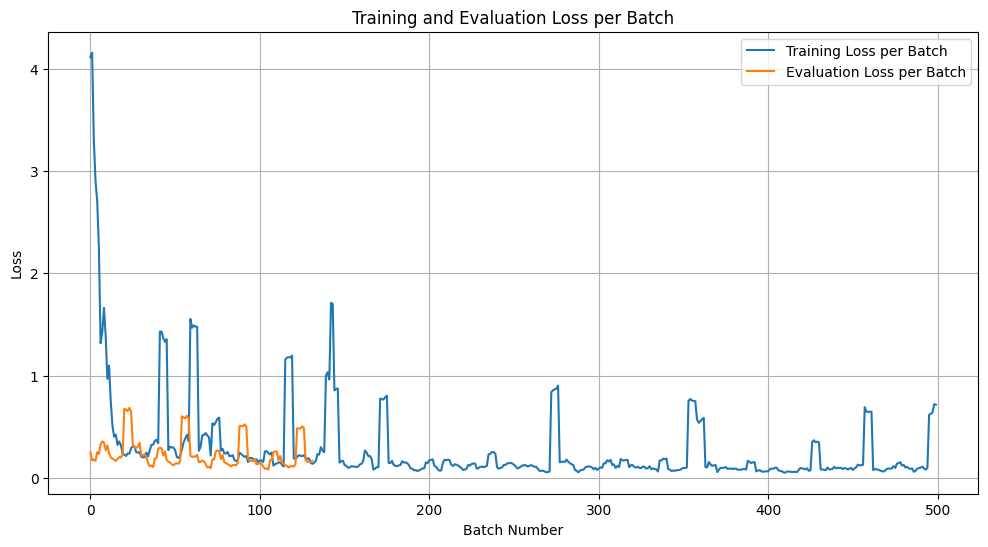

In [16]:
import matplotlib.pyplot as plt
import numpy as np

batch_losses = [x.cpu().numpy() for x in train_loss_per_batch if not torch.isnan(x)]
batch_eval_losses = [x.cpu().numpy() for x in eval_loss_per_batch if not torch.isnan(x)]

def moving_average(data, window_size):
    """ Calculate the moving average using a simple sliding window approach. """
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

# Example usage with a window size of 5
window_size = 5
smoothed_train_loss = moving_average(batch_losses, window_size)
smoothed_eval_loss = moving_average(batch_eval_losses, window_size)

plt.figure(figsize=(12, 6))
plt.plot(smoothed_train_loss, label='Training Loss per Batch')
plt.plot(smoothed_eval_loss, label='Evaluation Loss per Batch', linestyle='-')
plt.title('Training and Evaluation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
with open('eval_preds.txt', 'w') as f:
    for item in eval_preds:
        f.write("%s\n\n" % item)

# Push to the cloud

In [18]:
peft_model_id = "billyfin/llama_3_prompt_tuning_api2json_v4"
model.push_to_hub(peft_model_id, use_auth_token=True, private=True)

/workspace/IE/venv/lib/python3.10/site-packages/transformers/utils/hub.py:836: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/workspace/IE/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/328k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/billyfin/llama_3_prompt_tuning_api2json_v4/commit/3ee778d1791a5f59c2e29431a01b58ac3aa39229', commit_message='Upload model', commit_description='', oid='3ee778d1791a5f59c2e29431a01b58ac3aa39229', pr_url=None, pr_revision=None, pr_num=None)

# Load the model

In [ ]:
from peft import PeftModel, PeftConfig
from huggingface_hub import notebook_login
from transformers import AutoModelForCausalLM, AutoModel, AutoTokenizer, default_data_collator, get_linear_schedule_with_warmup, BitsAndBytesConfig
from peft import get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

notebook_login()

In [13]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

peft_model_id = "billyfin/llama_3_prompt_tuning_api2json_v3.0"

config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path,
                                             quantization_config=quant_config,
                                             low_cpu_mem_usage=True,
                                            )
model = PeftModel.from_pretrained(model, peft_model_id)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

# Test & Inference

In [34]:
test_sample = dataset['test']['text_content'][31]

print(test_sample)

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

PokÃ©mon TCG Developers PokÃ©mon TCG Developers JOIN THE COMMUNITY OF DEVELOPERS BUILDING WITH THE POKÃMON TCG API Next The most comprehensive dataset you can find From Base Set through Sword & Shield , the PokÃ©mon TCG API has the card data you need to build the ultimate application, whether that be mobile or web. Get access to prices, hi-res images, and more. Focus on your application and let us worry about the card data. Some features of the PokÃ©mon TCG API include: Prices by TCGplayer Hi-Res Images Detailed Search Queries Developer SDKs With a large community contributing to the project through various SDKs, development for you and your team has never been easier. In-depth details of every card All data delivered in JSON format such as types, attacks, abilities, and more. For Developers The PokÃ©mon TCG API allows developers to ingest card data programatically. The API exposes card and set details in an easy to consume fo

In [35]:
def preprocess_for_inference(examples):
    inputs = f"{examples}"
    
    model_inputs = tokenizer(inputs)
    model_inputs['input_ids'] += [tokenizer.pad_token_id]
    model_inputs["attention_mask"] = [1] * len(model_inputs["input_ids"])
    
    sample_input_ids = model_inputs["input_ids"]
    model_inputs["input_ids"] = [tokenizer.pad_token_id] * (
        max_length - len(sample_input_ids)
    ) + sample_input_ids
    model_inputs["attention_mask"] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
        "attention_mask"
    ]
    model_inputs["input_ids"] = torch.tensor(model_inputs["input_ids"][:max_length])
    model_inputs["attention_mask"] = torch.tensor(model_inputs["attention_mask"][:max_length])
    return model_inputs

test_input = preprocess_for_inference(test_sample)

test_input['input_ids'].shape, test_input['attention_mask'].shape

(torch.Size([10240]), torch.Size([10240]))

In [36]:
model.eval()

inputs = {k: v.unsqueeze(0).to(device) for k, v in test_input.items()}
prompt = inputs['input_ids'].shape[1]
with torch.no_grad():
    outputs = model.generate(
        input_ids=inputs["input_ids"], 
        attention_mask=inputs["attention_mask"],
        max_new_tokens=1024,
        temperature=0.1
    )

print(tokenizer.decode(outputs[0, prompt:], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{
    "title": "Meme API Documentation",
    "endpoints": [
        {
            "name": "Get Random Meme",
            "description": "Summon a random meme from the'memes', 'dankmemes','me_irl' subreddits.",
            "method": "GET",
            "url": "https://meme-api.com/gimme",
            "headers": [],
            "required_parameters": [],
            "optional_parameters": []
        },
        {
            "name": "Get Multiple Memes",
            "description": "Specify the count to get multiple memes in a single request.",
            "method": "GET",
            "url": "https://meme-api.com/gimme/{count}",
            "headers": [],
            "required_parameters": [
                {
                    "name": "count",
                    "type": "integer",
                    "description": "The number of memes to retrieve.",
                    "default": null,
                    "example": 2
                }
            ],
            "optional_parameters": [

In [52]:
print(dataset['test']['json_form'][3])

{
    "title": "TacoFancy API Documentation",
    "endpoints": [
        {
            "name": "Get Random Taco",
            "description": "Retrieves a random taco recipe including Base Layer, Mixin, Condiment, Seasoning, and Shell.",
            "method": "GET",
            "url": "http://taco-randomizer.herokuapp.com/random/",
            "headers": [],
            "required_parameters": [],
            "optional_parameters": [
                {
                    "name": "full-taco",
                    "type": "boolean",
                    "description": "If set to true, returns a full taco recipe.",
                    "default": false,
                    "example": true
                }
            ]
        },
        {
            "name": "Get Contributors for Recipe",
            "description": "Retrieves information about the contributors for a specific recipe.",
            "method": "GET",
            "url": "http://taco-randomizer.herokuapp.com/contributors/:recipe_t